In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geodata import generate_grid_dataframe,calculate_moran_i

In [2]:
grid_size = 10
r_seed = 42

In [3]:
gdf = generate_grid_dataframe(grid_size, autocorrelation="none", random_seed=r_seed)        # No spatial correlation
# gdf = generate_grid_dataframe(grid_size, autocorrelation="positive", random_seed=r_seed)  # Positive spatial correlation

In [4]:
# Calculate Moran’s I
moran = calculate_moran_i(gdf, grid_size)

# Display Moran's I values
print(f"Moran's I: {moran}")

Moran's I: -0.05438727909210017


Let's consider AC none - Generated data are v values and did not computed E theta or Y from poisson

In [5]:
n_regions = grid_size**2

In [6]:
import pymc as pm
import arviz as az
import pandas as pd

In [7]:
#BYM model

# get the values to a numpy array
values = gdf['Value'].values   # assue this as vi
# print(values)
Y = values*30
# print(Y)

# Expected number of cases per region (constant for simplicity)
E = np.full(n_regions, 30)

# Define the model
with pm.Model() as poisson_model_N:
    # Prior for random effect (Normal)
    vN_prior = pm.Normal("vN", mu=0.5, sigma=0.125, shape=n_regions)

    # Assuming you also have a spatial effect uN_prior (add it if it's missing)
    uN_prior = pm.Normal("uN", mu=0, sigma=1, shape=n_regions)  # Adjust parameters as needed

    # Define risk parameter
    thetaN = pm.Deterministic("thetaN", pm.math.exp(pm.math.log(E) + uN_prior + vN_prior))

    Y_obs_N = pm.Poisson("Y_obs_N", mu=thetaN, observed=Y)

    # Sample the model

    trace_N = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vN, uN]


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [8]:
# Extract vN samples from the trace
vN_samples = trace_N.posterior["vN"]  # 
uN_samples = trace_N.posterior["uN"]  #

In [9]:
vN_array = np.array(trace_N.posterior["vN"])  # Shape: (chains, samples, n_regions)
uN_array = np.array(trace_N.posterior["uN"])  # Shape: (chains, samples, n_regions)

In [10]:
vN_mean = vN_array.mean(axis=(0, 1))  # Average over chains & samples
uN_mean = uN_array.mean(axis=(0, 1))  # Average over chains & samples


In [11]:
# add this to gdf_none
gdf['vN'] = vN_mean
gdf['uN'] = uN_mean

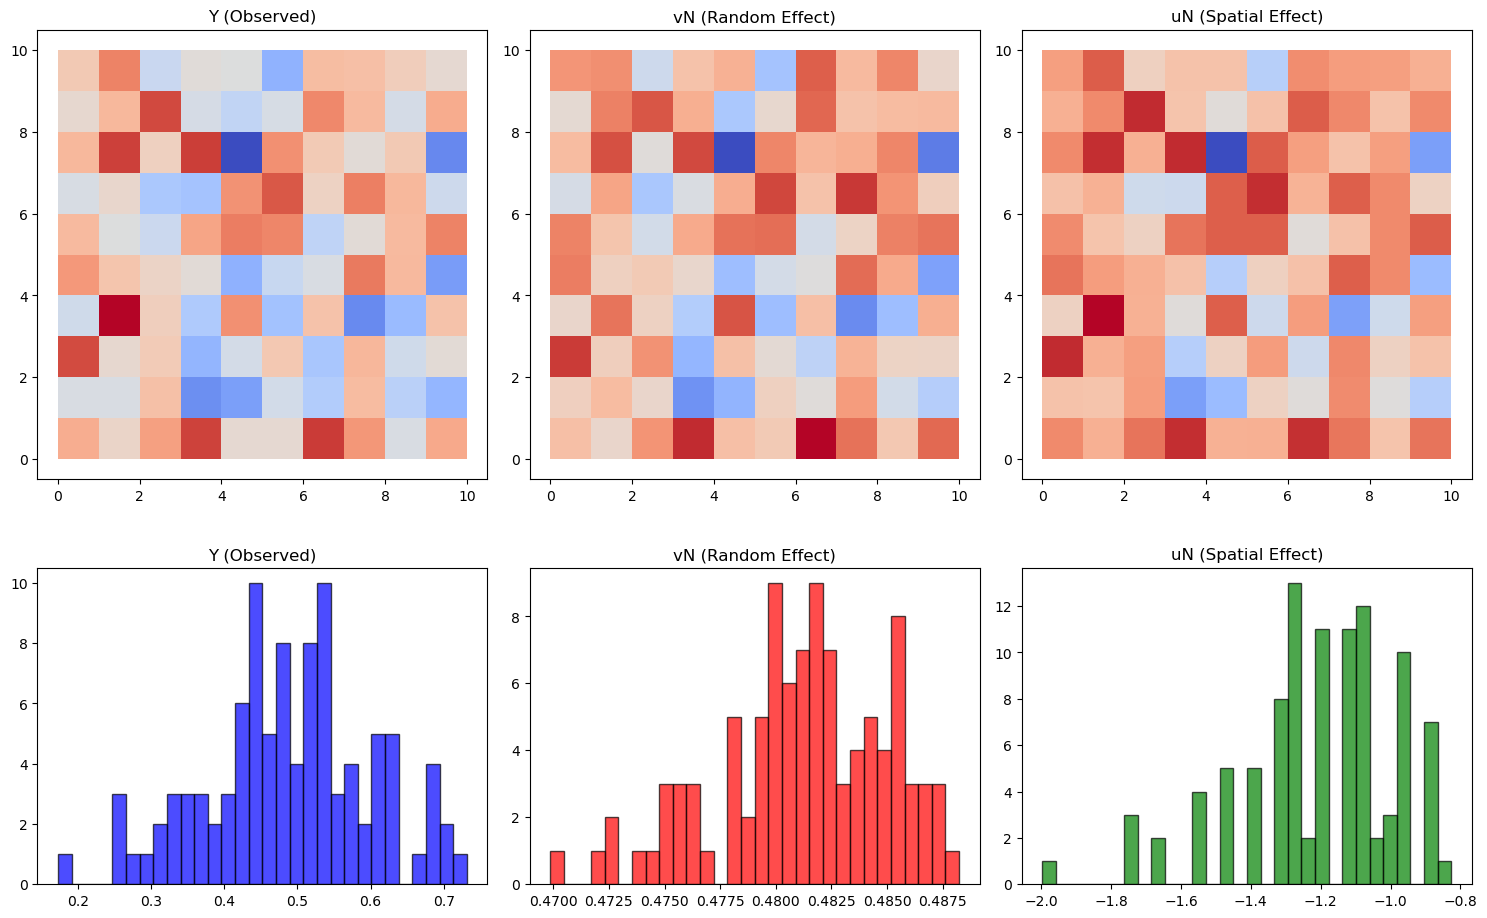

In [12]:
# Create figure with two rows: one for maps, one for histograms
fig, axs = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot the maps
gdf.plot(column='Value', cmap='coolwarm', legend=False, ax=axs[0, 0])
gdf.plot(column='vN', cmap='coolwarm', legend=False, ax=axs[0, 1])
gdf.plot(column='uN', cmap='coolwarm', legend=False, ax=axs[0, 2])

# Set titles for maps
axs[0, 0].set_title("Y (Observed)")
axs[0, 1].set_title("vN (Random Effect)")
axs[0, 2].set_title("uN (Spatial Effect)")

# Plot histograms
axs[1, 0].hist(gdf['Value'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axs[1, 1].hist(gdf['vN'], bins=30, color='red', alpha=0.7, edgecolor='black')
axs[1, 2].hist(gdf['uN'], bins=30, color='green', alpha=0.7, edgecolor='black')

# Set titles for histograms
axs[1, 0].set_title("Y (Observed)")
axs[1, 1].set_title("vN (Random Effect)")
axs[1, 2].set_title("uN (Spatial Effect)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [13]:
gdf.head()

,Index,Value,geometry,vN,uN
0,0,0.562089,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))",0.481669,-1.075898
1,1,0.482717,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))",0.479948,-1.191645
2,2,0.580961,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))",0.483892,-1.020523
3,3,0.690379,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))",0.487527,-0.872759
4,4,0.470731,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))",0.481679,-1.192970


In [14]:
test = gdf[['Value','vN','uN','geometry']]

In [15]:
from adjacency_simplex import AdjacencySimplex  # Import the class
from plot_utills import plot_simplicial_complex_gif
from calculate_tda_summaries import compute_persistence

In [16]:
variable = ['vN','uN']
filter_method = ['up','down']


for var in variable:
    for filter in filter_method:

        # Initialize the AdjacencySimplex class
        adj_simplex = AdjacencySimplex(test, var, threshold = None, filter_method = filter)

        # Filter the GeoDataFrame
        filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

        # Calculate the adjacent countries
        adj_simplex.calculate_adjacent_countries()

        # Form the simplicial complex
        simplex = adj_simplex.form_simplicial_complex()

        total_h0_points, tl, al, tml, aml = compute_persistence(simplex,filtered_df, var)

        print(f'Variable: {var} - Filter: {filter}')

        # up for vN - positive spatial correlation
        print('Total number of H0 points:', total_h0_points)
        print('Total  lifespan:', tl)
        print('Average lifespan:', al)
        print('Total mid lifespan:', tml)
        print('Average mid lifespan:', aml)

        print('----------------------') 

    

Variable: vN - Filter: up
Total number of H0 points: 100
Total  lifespan: 63.69431415839917
Average lifespan: 0.6369431415839917
Total mid lifespan: 31.847157079199587
Average mid lifespan: 0.31847157079199584
----------------------
Variable: vN - Filter: down
Total number of H0 points: 100
Total  lifespan: 63.092093644091285
Average lifespan: 0.6309209364409128
Total mid lifespan: 31.546046822045643
Average mid lifespan: 0.3154604682204564
----------------------
Variable: uN - Filter: up
Total number of H0 points: 7
Total  lifespan: 18.290133743619027
Average lifespan: 2.6128762490884325
Total mid lifespan: -0.5921054173882316
Average mid lifespan: -0.08458648819831881
----------------------
Variable: uN - Filter: down
Total number of H0 points: 5
Total  lifespan: 18.985037289907456
Average lifespan: 3.797007457981491
Total mid lifespan: 0.8970512715323293
Average mid lifespan: 0.17941025430646587
----------------------
